In [27]:
import math

In [33]:
class neuron:
    def __init__(self, weights, bias, num_inp):
        self.weights = weights if weights is not None else [0.1 for _ in range(num_inp)]
        self.bias = bias if bias is not None else 1
        self.last_inp = None
        self.last_activation_input = None
        self.last_weighted_sum = None
        self.weight_gradients = None
        self.bias_gradient = None

    def calc_weighted_sum(self, inputs):
        weighted_sum = 0.0
        for i in range(len(inputs)):
            weighted_sum += inputs[i] * self.weights[i]
        weighted_sum += self.bias
        self.last_inp = inputs
        self.last_activation_input = weighted_sum
        self.last_weighted_sum = weighted_sum
        return weighted_sum

    def activation_func(self, weighted_sum):
        output = weighted_sum * (1.0 / (1.0 + math.exp(-weighted_sum)))
        self.last_activation_output = output
        return output

    def forward(self, inputs):
        weighted_sum = self.calc_weighted_sum(inputs)
        return self.activation_func(weighted_sum)

    def derivative_swish(self):
        x = self.last_weighted_sum
        return (math.e ** x) * ((math.e ** x) + x + 1) / (((math.e ** x) + 1) ** 2)

    def update_weights(self, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.weight_gradients[i]
        self.bias -= learning_rate * self.bias_gradient

In [34]:
class layer:
    def __init__(self, num_of_neurons, num_of_inputs_per_neuron):
        self.neurons = []
        for i in range(num_of_neurons):
            neuron_instance = neuron(None, 1, num_of_inputs_per_neuron)
            self.neurons.append(neuron_instance)
        self.last_output = None
        self.error_gradients = None

    def forward_prop(self, inputs):
        output = []
        for neuron in self.neurons:
            output.append(neuron.forward(inputs))
        return output

    def calculate_gradients(self, next_layer_gradients=None, next_layer=None):
        self.error_gradients = []
        for i, neuron in enumerate(self.neurons):
            if next_layer is None:
                gradient = next_layer_gradients[i]
            else:
                gradient = 0
                for j, next_neuron in enumerate(next_layer.neurons):
                    gradient += next_neuron.weights[i] * next_layer_gradients[j]
                gradient *= neuron.derivative_swish()
            self.error_gradients.append(gradient)
            neuron.weight_gradients = []
            for input_val in neuron.last_inp:
                weight_gradient = gradient * input_val
                neuron.weight_gradients.append(weight_gradient)
            neuron.bias_gradient = gradient

    def update_weights(self, learning_rate):
        for neuron in self.neurons:
            neuron.update_weights(learning_rate)

    def get_weights(self):
        weights = []
        for neuron in self.neurons:
            weights.append(neuron.weights)
        return weights

    def get_outputs(self):
        return self.last_output

In [35]:
class neural_nets:
    def __init__(self, num_of_inputs, layer_sizes):
        self.layers = []
        prev_size = num_of_inputs
        for size in layer_sizes:
            layer_obj = layer(num_of_neurons=size, num_of_inputs_per_neuron=prev_size)
            self.layers.append(layer_obj)
            prev_size = size

    def forward_prop(self, inputs):
        current_inputs = inputs
        for layer_instance in self.layers:
            current_inputs = layer_instance.forward_prop(current_inputs)
        return current_inputs

    def loss_calc(self, target):
        output_layer = self.layers[-1]
        output = [neuron.last_activation_output for neuron in output_layer.neurons]
        return sum((o - t)**2 for o, t in zip(output, target)) / len(output)

    def backward(self, target):
        output_layer = self.layers[-1]

        deltas = []
        for neuron, t in zip(output_layer.neurons, target):
            dL_da = neuron.last_activation_output - t

            da_dz = neuron.derivative_swish()

            delta = dL_da * da_dz
            deltas.append(delta)

        output_layer.calculate_gradients(next_layer_gradients=deltas, next_layer=None)

        for i in reversed(range(len(self.layers) - 1)):
            current_layer = self.layers[i]
            next_layer = self.layers[i + 1]
            current_layer.calculate_gradients(
                next_layer_gradients=next_layer.error_gradients,
                next_layer=next_layer
            )

    def train(self, input_data, target, learning_rate):
        self.forward_prop(input_data)
        self.backward(target)
        for layer in self.layers:
            layer.update_weights(learning_rate)

    def predict(self, input_data):
        return self.forward_prop(input_data)

    def get_weights(self):
        weights = []
        for layer in self.layers:
            weights.append(layer.get_weights())
        return weights

In [38]:
#tested and visualised using claude
import matplotlib.pyplot as plt
import math

def create_xor_dataset():
    inputs = [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ]

    outputs = [
        [0],
        [1],
        [1],
        [0]
    ]

    return inputs, outputs

def create_pattern_recognition_dataset():
    # Simple pattern: if sum of inputs is greater than 1.5, output is 1
    inputs = [
        [0, 0],
        [0, 0.5],
        [0.5, 0],
        [1, 0.5],
        [0.5, 1],
        [1, 1],
        [0.5, 0.5],
        [1, 0],
        [0, 1]
    ]

    outputs = [
        [0],  # 0 + 0 = 0
        [0],  # 0 + 0.5 = 0.5
        [0],  # 0.5 + 0 = 0.5
        [1],  # 1 + 0.5 = 1.5
        [1],  # 0.5 + 1 = 1.5
        [1],  # 1 + 1 = 2
        [0],  # 0.5 + 0.5 = 1
        [1],  # 1 + 0 = 1
        [1]   # 0 + 1 = 1
    ]

    return inputs, outputs

def visualize_training(losses, predictions, actual_values):
    plt.figure(figsize=(15, 5))

    # Plot 1: Loss over iterations
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-', label='Training Loss')
    plt.title('Loss Over Training Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Predictions vs Actual Values
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(predictions)), predictions, c='b', label='Predictions', alpha=0.5)
    plt.scatter(range(len(actual_values)), actual_values, c='r', label='Actual Values', alpha=0.5)
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_and_visualize(network, inputs, targets, learning_rate=0.1, epochs=1000):
    losses = []
    final_predictions = []
    actual_values = [t[0] for t in targets]

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_predictions = []

        for i in range(len(inputs)):
            # Forward pass
            prediction = network.forward_prop(inputs[i])
            epoch_predictions.append(prediction[0])

            # Calculate loss
            loss = network.loss_calc(targets[i])
            epoch_loss += loss

            # Backward pass and update weights
            network.backward(targets[i])
            for layer in network.layers:
                layer.update_weights(learning_rate)

        avg_loss = epoch_loss / len(inputs)
        losses.append(avg_loss)

        if epoch == epochs - 1:
            final_predictions = epoch_predictions

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    visualize_training(losses, final_predictions, actual_values)

    # Test predictions
    print("\nFinal Predictions:")
    for i in range(len(inputs)):
        pred = network.forward_prop(inputs[i])
        print(f"Input: {inputs[i]}, Target: {targets[i]}, Prediction: {pred[0]:.4f}")

# Example usage
def main():
    # Create network with 2 inputs, 4 hidden neurons, and 1 output neuron
    network = neural_nets(2, [4, 1])

    # Create dataset
    inputs, targets = create_pattern_recognition_dataset()

    # Train and visualize
    train_and_visualize(network, inputs, targets, learning_rate=0.01, epochs=1000)

Epoch 0, Loss: 0.4308
Epoch 100, Loss: 0.2485
Epoch 200, Loss: 0.2352
Epoch 300, Loss: 0.2063
Epoch 400, Loss: 0.1654
Epoch 500, Loss: 0.1335
Epoch 600, Loss: 0.1186
Epoch 700, Loss: 0.1135
Epoch 800, Loss: 0.1119
Epoch 900, Loss: 0.1115


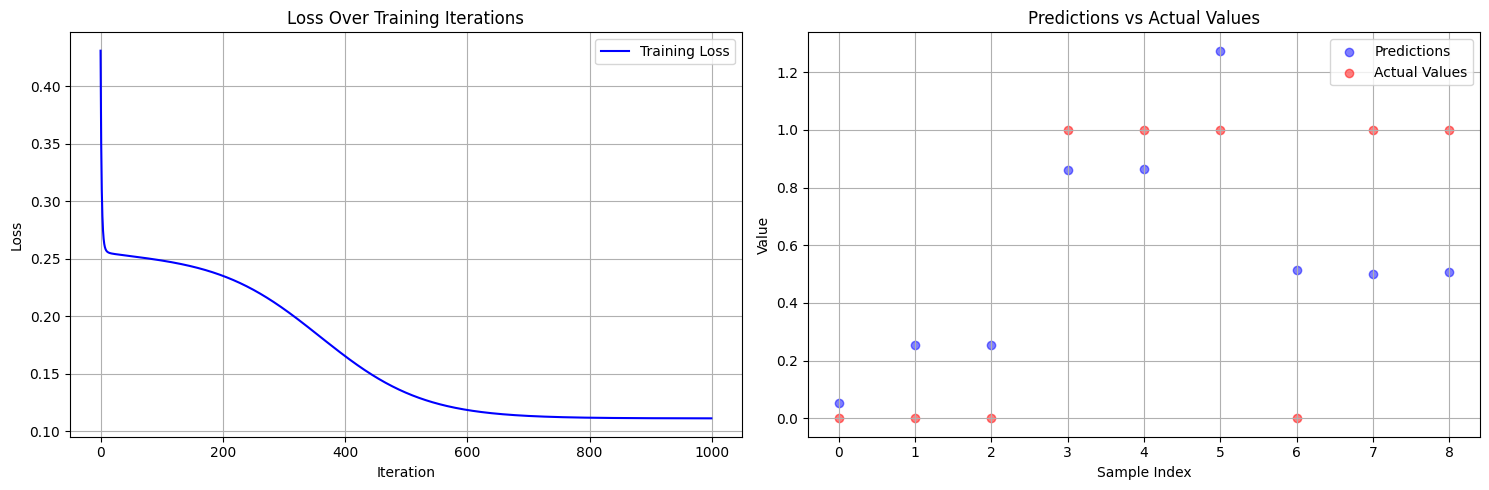


Final Predictions:
Input: [0, 0], Target: [0], Prediction: 0.0522
Input: [0, 0.5], Target: [0], Prediction: 0.2548
Input: [0.5, 0], Target: [0], Prediction: 0.2604
Input: [1, 0.5], Target: [1], Prediction: 0.8822
Input: [0.5, 1], Target: [1], Prediction: 0.8736
Input: [1, 1], Target: [1], Prediction: 1.2714
Input: [0.5, 0.5], Target: [0], Prediction: 0.5348
Input: [1, 0], Target: [1], Prediction: 0.5420
Input: [0, 1], Target: [1], Prediction: 0.5276


In [37]:
main()